In [1]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from google.colab import drive
import zipfile
from tqdm import tqdm

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.9 MB/s eta 0:00:00


In [3]:
import mediapipe as mp
from torch.utils.data import Dataset, DataLoader

In [4]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/project_data/processed_dataset.zip'
extract_path = '/content/dataset'

In [ ]:
os.makedirs(extract_path, exist_ok=True)
print("Created extraction directory at:", extract_path)

Created extraction directory at: /content/dataset


In [ ]:
print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted to:", extract_path)

Extracting dataset...
Dataset extracted to: /content/dataset


In [ ]:
dataset_path = os.path.join(extract_path, 'processed_dataset')
classes = ['hello', 'negative', 'thank_you']

In [ ]:
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        videos = [f for f in os.listdir(class_path) if f.endswith('.mp4')]
        print(f"Class {class_name}: {len(videos)} videos")


Class hello: 424 videos
Class negative: 1400 videos
Class thank_you: 472 videos


In [ ]:
def inspect_video(video_path):
    cap = cv2.VideoCapture(video_path)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cap.release()

    return {
        'width': width,
        'height': height,
        'fps': fps,
        'frame_count': frame_count
    }

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
import h5py
import json
from tqdm import tqdm

class LandmarkFeatureExtractor:
    def __init__(
        self,
        dataset_path,
        output_path,
        sequence_length=128,
        image_size=(128, 128)
    ):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.sequence_length = sequence_length
        self.image_size = image_size

        os.makedirs(output_path, exist_ok=True)

        self.classes = ['hello', 'negative', 'thank_you']

        self.metadata = {
            'total_videos': 0,
            'processed_videos': 0,
            'class_distribution': {cls: 0 for cls in self.classes},
            'feature_shape': None
        }

    def process_video(self, video_path):
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Could not open video: {video_path}")
                return None

            mp_hands = mp.solutions.hands
            with mp_hands.Hands(
                static_image_mode=False,
                max_num_hands=1,
                min_detection_confidence=0.5
            ) as hands:

                landmarks_sequence = []

                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame = cv2.resize(frame, self.image_size)
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    results = hands.process(frame_rgb)

                    if results.multi_hand_landmarks:
                        landmarks = results.multi_hand_landmarks[0]
                        features = []
                        for landmark in landmarks.landmark:
                            features.extend([landmark.x, landmark.y, landmark.z])
                        landmarks_sequence.append(features)
                    else:
                        landmarks_sequence.append(np.zeros(21 * 3))

                cap.release()

                landmarks_sequence = np.array(landmarks_sequence, dtype=np.float32)

                if len(landmarks_sequence) > self.sequence_length:

                    start = (len(landmarks_sequence) - self.sequence_length) // 2
                    landmarks_sequence = landmarks_sequence[start:start + self.sequence_length]
                else:
                    padding = np.zeros(
                        (self.sequence_length - len(landmarks_sequence), 21 * 3),
                        dtype=np.float32
                    )
                    landmarks_sequence = np.concatenate([landmarks_sequence, padding])

                return landmarks_sequence

        except Exception as e:
            print(f"Error processing video {video_path}: {e}")
            return None

    def extract_features(self):
        hdf5_path = os.path.join(self.output_path, 'landmark_features.h5')

        metadata_path = os.path.join(self.output_path, 'dataset_metadata.json')

        with h5py.File(hdf5_path, 'w') as h5file:

            for cls in self.classes:
                class_group = h5file.create_group(cls)

                class_dir = os.path.join(self.dataset_path, cls)
                video_files = [
                    f for f in os.listdir(class_dir)
                    if f.endswith('.mp4')
                ]

                for video_file in tqdm(video_files, desc=f'Processing {cls} class'):
                    video_path = os.path.join(class_dir, video_file)

                    features = self.process_video(video_path)

                    if features is not None:
                        class_group.create_dataset(
                            video_file,
                            data=features,
                            compression='gzip'
                        )

                        self.metadata['total_videos'] += 1
                        self.metadata['processed_videos'] += 1
                        self.metadata['class_distribution'][cls] += 1

                        if self.metadata['feature_shape'] is None:
                            self.metadata['feature_shape'] = features.shape

        with open(metadata_path, 'w') as f:
            json.dump(self.metadata, f, indent=4)

        print("\nFeature Extraction Complete!")
        print(f"Total Videos Processed: {self.metadata['total_videos']}")
        print("Class Distribution:", self.metadata['class_distribution'])
        print(f"Feature Shape: {self.metadata['feature_shape']}")

def main():
    dataset_path = '/content/dataset/processed_dataset'
    output_path = '/content/dataset/landmark_features'

    extractor = LandmarkFeatureExtractor(
        dataset_path=dataset_path,
        output_path=output_path
    )
    extractor.extract_features()

if __name__ == '__main__':
    main()

Processing thank_you class: 100%|██████████| 472/472 [05:00<00:00,  1.57it/s]


Feature Extraction Complete!
Total Videos Processed: 2296
Class Distribution: {'hello': 424, 'negative': 1400, 'thank_you': 472}
Feature Shape: (128, 63)


In [5]:
from google.colab import drive
import shutil
import os

drive.mount('/content/drive')

source_h5_path = '/content/dataset/landmark_features/landmark_features.h5'
source_metadata_path = '/content/dataset/landmark_features/dataset_metadata.json'

destination_h5_path = '/content/drive/MyDrive/project_data/landmark_features.h5'
destination_metadata_path = '/content/drive/MyDrive/project_data/dataset_metadata.json'

os.makedirs(os.path.dirname(destination_h5_path), exist_ok=True)
try:

    shutil.copy2(source_h5_path, destination_h5_path)
    print(f"Successfully copied {source_h5_path} to {destination_h5_path}")

    if os.path.exists(destination_h5_path):
        h5_file_size = os.path.getsize(destination_h5_path)
        print(f"H5 file size: {h5_file_size / (1024 * 1024):.2f} MB")

    shutil.copy2(source_metadata_path, destination_metadata_path)
    print(f"Successfully copied {source_metadata_path} to {destination_metadata_path}")

    if os.path.exists(destination_metadata_path):
        metadata_file_size = os.path.getsize(destination_metadata_path)
        print(f"Metadata file size: {metadata_file_size} bytes")

except Exception as e:
    print(f"An error occurred: {e}")

try:
    import json
    with open(destination_metadata_path, 'r') as f:
        metadata = json.load(f)
    print("\nMetadata Contents:")
    print(json.dumps(metadata, indent=2))
except Exception as e:
    print(f"Could not read metadata: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
An error occurred: [Errno 2] No such file or directory: '/content/dataset/landmark_features/landmark_features.h5'

Metadata Contents:
{
  "total_videos": 2296,
  "processed_videos": 2296,
  "class_distribution": {
    "hello": 424,
    "negative": 1400,
    "thank_you": 472
  },
  "feature_shape": [
    128,
    63
  ]
}


In [6]:
import os
import h5py
import json
import torch
from torch.utils.data import Dataset, random_split
import numpy as np
from google.colab import drive

class LandmarkFeatureDataset(Dataset):
    def __init__(
        self,
        features_path=None,
        subset='train',
        train_split=0.7,
        val_split=0.15,
        seed=42
    ):
        try:
            drive.mount('/content/drive', force_remount=False)
        except Exception:
            pass
        if features_path is None:
            features_path = '/content/drive/MyDrive/project_data/landmark_features.h5'

        self.features_path = features_path
        self.subset = subset
        self.train_split = train_split
        self.val_split = val_split

        np.random.seed(seed)

        metadata_path = os.path.join(
            os.path.dirname(features_path),
            'dataset_metadata.json'
        )
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)

        self._load_features()

    def _load_features(self):
        all_features = []
        all_labels = []

        class_to_idx = {
            'hello': 0,
            'negative': 1,
            'thank_you': 2
        }
        with h5py.File(self.features_path, 'r') as h5file:
            for class_name, class_group in h5file.items():
                class_features = list(class_group.values())

                for feature in class_features:
                    all_features.append(feature[()])
                    all_labels.append(class_to_idx[class_name])

        all_features = np.array(all_features)
        all_labels = np.array(all_labels)

        total_samples = len(all_labels)
        train_end = int(total_samples * self.train_split)
        val_end = train_end + int(total_samples * self.val_split)

        shuffle_indices = np.arange(total_samples)
        np.random.shuffle(shuffle_indices)

        if self.subset == 'train':
            start, end = 0, train_end
            subset_name = 'Training'
        elif self.subset == 'val':
            start, end = train_end, val_end
            subset_name = 'Validation'
        elif self.subset == 'test':
            start, end = val_end, total_samples
            subset_name = 'Testing'
        else:
            raise ValueError("Subset must be 'train', 'val', or 'test'")

        self.features = all_features[shuffle_indices[start:end]]
        self.labels = all_labels[shuffle_indices[start:end]]

        print(f"{subset_name} set:")
        print(f"Total samples: {len(self.features)}")
        print("Label distribution:",
              {k: list(self.labels).count(v) for k, v in class_to_idx.items()})

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.from_numpy(self.features[idx]).float()
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label

def get_data_loaders(
    features_path=None,
    batch_size=32,
    num_workers=4,
    pin_memory=True
):
    from torch.utils.data import DataLoader

    train_dataset = LandmarkFeatureDataset(
        features_path,
        subset='train'
    )
    val_dataset = LandmarkFeatureDataset(
        features_path,
        subset='val'
    )
    test_dataset = LandmarkFeatureDataset(
        features_path,
        subset='test'
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_loader, val_loader, test_loader

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/project_data/training_history.png')
    plt.show()

def evaluate_model(model, test_loader, device, classes):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        total_samples = 0
        correct_predictions = 0

        class_correct = {i: 0 for i in range(len(classes))}
        class_total = {i: 0 for i in range(len(classes))}

        for batch_landmarks, labels in test_loader:
            batch_landmarks = batch_landmarks.to(device)
            labels = labels.to(device)

            outputs = model(batch_landmarks)

            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        overall_accuracy = 100 * correct_predictions / total_samples
        print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

        print("\nPer-Class Test Accuracy:")
        for i, class_name in enumerate(classes):
            class_acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            print(f"{class_name}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})")

        report = classification_report(
            all_labels,
            all_preds,
            target_names=classes,
            output_dict=True
        )

        print("\nDetailed Classification Report:")
        print(classification_report(
            all_labels,
            all_preds,
            target_names=classes
        ))

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/project_data/confusion_matrix.png')
        plt.show()

        return report, cm

def load_saved_model(model_path, model_class, device):
    """
    Load a previously saved model

    Args:
        model_path (str): Path to saved model file
        model_class (type): Model class used for instantiation
        device (torch.device): Device to load model to

    Returns:
        tuple: (loaded model, optimizer state, training history, classes)
    """
    checkpoint = torch.load(model_path, map_location=device)

    model = model_class(
        input_size=63,
        hidden_size=128,
        num_classes=len(checkpoint['classes'])
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    return (
        model,
        checkpoint.get('optimizer_state_dict', None),
        checkpoint.get('history', None),
        checkpoint['classes']
    )

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set:
Total samples: 1607
Label distribution: {'hello': 321, 'negative': 956, 'thank_you': 330}
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Validation set:
Total samples: 344
Label distribution: {'hello': 49, 'negative': 225, 'thank_you': 70}
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Testing set:
Total samples: 345
Label distribution: {'hello': 54, 'negative': 219, 'thank_you': 72}
Class Weights:
hello: 1.34
negative: 0.74
thank_you: 1.27

Epoch [1/50]



Epoch Summary:
Learning Rate: 0.000110
Train Loss: 1.1415, Train Acc: 38.39%
Val Loss: 1.0856, Val Acc: 29.65%

Per-Class Training Accuracy:
hello: 55.14% (177/321)
negative: 34.94% (334/956)
thank_you: 32.12% (106/330)

Per-Class Validation Accuracy:
hello: 100.00% (49/49)
negative: 23.56% (53/225)
thank_you: 0.00% (0/70)

🌟 New Best Model! Validation Accuracy improved by 29.65%
Best model saved to /content/drive/MyDrive/project_data/best_asl_landmark_model.pth

Time Stats:
Elapsed Time: 0.06 mins
Est. Remaining: 2.96 mins

Epoch [2/50]



Epoch Summary:
Learning Rate: 0.000139
Train Loss: 0.9397, Train Acc: 55.20%
Val Loss: 0.8005, Val Acc: 75.29%

Per-Class Training Accuracy:
hello: 69.78% (224/321)
negative: 55.02% (526/956)
thank_you: 41.52% (137/330)

Per-Class Validation Accuracy:
hello: 79.59% (39/49)
negative: 78.22% (176/225)
thank_you: 62.86% (44/70)

🌟 New Best Model! Validation Accuracy improved by 45.64%
Best model saved to /content/drive/MyDrive/project_data/best_asl_landmark_model.pth

Time Stats:
Elapsed Time: 0.10 mins
Est. Remaining: 2.42 mins

Epoch [3/50]



Epoch Summary:
Learning Rate: 0.000186
Train Loss: 0.7558, Train Acc: 67.77%
Val Loss: 0.7216, Val Acc: 76.45%

Per-Class Training Accuracy:
hello: 83.49% (268/321)
negative: 67.68% (647/956)
thank_you: 52.73% (174/330)

Per-Class Validation Accuracy:
hello: 93.88% (46/49)
negative: 75.56% (170/225)
thank_you: 67.14% (47/70)

🌟 New Best Model! Validation Accuracy improved by 1.16%
Best model saved to /content/drive/MyDrive/project_data/best_asl_landmark_model.pth

Time Stats:
Elapsed Time: 0.14 mins
Est. Remaining: 2.22 mins

Epoch [4/50]



Epoch Summary:
Learning Rate: 0.000249
Train Loss: 0.5211, Train Acc: 80.46%
Val Loss: 0.2760, Val Acc: 91.28%

Per-Class Training Accuracy:
hello: 84.74% (272/321)
negative: 82.85% (792/956)
thank_you: 69.39% (229/330)

Per-Class Validation Accuracy:
hello: 79.59% (39/49)
negative: 92.89% (209/225)
thank_you: 94.29% (66/70)

🌟 New Best Model! Validation Accuracy improved by 14.83%
Best model saved to /content/drive/MyDrive/project_data/best_asl_landmark_model.pth

Time Stats:
Elapsed Time: 0.18 mins
Est. Remaining: 2.12 mins

Epoch [5/50]



Epoch Summary:
Learning Rate: 0.000326
Train Loss: 0.2832, Train Acc: 90.42%
Val Loss: 0.1171, Val Acc: 97.97%

Per-Class Training Accuracy:
hello: 88.16% (283/321)
negative: 92.36% (883/956)
thank_you: 86.97% (287/330)

Per-Class Validation Accuracy:
hello: 91.84% (45/49)
negative: 99.56% (224/225)
thank_you: 97.14% (68/70)

🌟 New Best Model! Validation Accuracy improved by 6.69%
Best model saved to /content/drive/MyDrive/project_data/best_asl_landmark_model.pth

Time Stats:
Elapsed Time: 0.22 mins
Est. Remaining: 2.02 mins

Epoch [6/50]



Epoch Summary:
Learning Rate: 0.000412
Train Loss: 0.1949, Train Acc: 94.46%
Val Loss: 0.1603, Val Acc: 96.51%

Per-Class Training Accuracy:
hello: 92.52% (297/321)
negative: 95.40% (912/956)
thank_you: 93.64% (309/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 98.22% (221/225)
thank_you: 91.43% (64/70)

Time Stats:
Elapsed Time: 0.26 mins
Est. Remaining: 1.92 mins

Epoch [7/50]



Epoch Summary:
Learning Rate: 0.000504
Train Loss: 0.1704, Train Acc: 95.46%
Val Loss: 0.2843, Val Acc: 92.73%

Per-Class Training Accuracy:
hello: 92.83% (298/321)
negative: 96.55% (923/956)
thank_you: 94.85% (313/330)

Per-Class Validation Accuracy:
hello: 69.39% (34/49)
negative: 100.00% (225/225)
thank_you: 85.71% (60/70)

Time Stats:
Elapsed Time: 0.30 mins
Est. Remaining: 1.84 mins

Epoch [8/50]



Epoch Summary:
Learning Rate: 0.000598
Train Loss: 0.2226, Train Acc: 93.09%
Val Loss: 0.1321, Val Acc: 95.64%

Per-Class Training Accuracy:
hello: 93.15% (299/321)
negative: 94.87% (907/956)
thank_you: 87.88% (290/330)

Per-Class Validation Accuracy:
hello: 93.88% (46/49)
negative: 95.56% (215/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 0.34 mins
Est. Remaining: 1.78 mins

Epoch [9/50]



Epoch Summary:
Learning Rate: 0.000690
Train Loss: 0.1559, Train Acc: 96.20%
Val Loss: 0.1488, Val Acc: 96.22%

Per-Class Training Accuracy:
hello: 95.33% (306/321)
negative: 97.07% (928/956)
thank_you: 94.55% (312/330)

Per-Class Validation Accuracy:
hello: 89.80% (44/49)
negative: 97.33% (219/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 0.38 mins
Est. Remaining: 1.73 mins

Epoch [10/50]



Epoch Summary:
Learning Rate: 0.000776
Train Loss: 0.1722, Train Acc: 96.33%
Val Loss: 0.2167, Val Acc: 96.22%

Per-Class Training Accuracy:
hello: 95.64% (307/321)
negative: 96.55% (923/956)
thank_you: 96.36% (318/330)

Per-Class Validation Accuracy:
hello: 89.80% (44/49)
negative: 98.22% (221/225)
thank_you: 94.29% (66/70)

Time Stats:
Elapsed Time: 0.42 mins
Est. Remaining: 1.67 mins

Epoch [11/50]



Epoch Summary:
Learning Rate: 0.000852
Train Loss: 0.1951, Train Acc: 95.89%
Val Loss: 0.1305, Val Acc: 97.97%

Per-Class Training Accuracy:
hello: 95.02% (305/321)
negative: 97.07% (928/956)
thank_you: 93.33% (308/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 92.86% (65/70)

Time Stats:
Elapsed Time: 0.46 mins
Est. Remaining: 1.62 mins

Epoch [12/50]



Epoch Summary:
Learning Rate: 0.000915
Train Loss: 0.2718, Train Acc: 93.96%
Val Loss: 0.2243, Val Acc: 93.90%

Per-Class Training Accuracy:
hello: 91.90% (295/321)
negative: 96.13% (919/956)
thank_you: 89.70% (296/330)

Per-Class Validation Accuracy:
hello: 91.84% (45/49)
negative: 93.33% (210/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 0.49 mins
Est. Remaining: 1.56 mins

Epoch [13/50]



Epoch Summary:
Learning Rate: 0.000962
Train Loss: 0.2615, Train Acc: 94.65%
Val Loss: 0.2398, Val Acc: 95.64%

Per-Class Training Accuracy:
hello: 90.03% (289/321)
negative: 96.34% (921/956)
thank_you: 94.24% (311/330)

Per-Class Validation Accuracy:
hello: 77.55% (38/49)
negative: 99.56% (224/225)
thank_you: 95.71% (67/70)

Time Stats:
Elapsed Time: 0.53 mins
Est. Remaining: 1.51 mins

Epoch [14/50]



Epoch Summary:
Learning Rate: 0.000991
Train Loss: 0.1956, Train Acc: 96.14%
Val Loss: 0.2123, Val Acc: 96.51%

Per-Class Training Accuracy:
hello: 94.08% (302/321)
negative: 96.97% (927/956)
thank_you: 95.76% (316/330)

Per-Class Validation Accuracy:
hello: 87.76% (43/49)
negative: 100.00% (225/225)
thank_you: 91.43% (64/70)

Time Stats:
Elapsed Time: 0.57 mins
Est. Remaining: 1.47 mins

Epoch [15/50]



Epoch Summary:
Learning Rate: 0.001000
Train Loss: 0.1292, Train Acc: 97.88%
Val Loss: 0.6641, Val Acc: 76.45%

Per-Class Training Accuracy:
hello: 97.20% (312/321)
negative: 98.54% (942/956)
thank_you: 96.67% (319/330)

Per-Class Validation Accuracy:
hello: 75.51% (37/49)
negative: 100.00% (225/225)
thank_you: 1.43% (1/70)

Time Stats:
Elapsed Time: 0.61 mins
Est. Remaining: 1.42 mins

Epoch [16/50]



Epoch Summary:
Learning Rate: 0.000998
Train Loss: 1.0945, Train Acc: 63.60%
Val Loss: 1.5860, Val Acc: 20.35%

Per-Class Training Accuracy:
hello: 49.84% (160/321)
negative: 73.33% (701/956)
thank_you: 48.79% (161/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 0.00% (0/225)
thank_you: 100.00% (70/70)

Time Stats:
Elapsed Time: 0.65 mins
Est. Remaining: 1.38 mins

Epoch [17/50]



Epoch Summary:
Learning Rate: 0.000992
Train Loss: 1.2316, Train Acc: 42.19%
Val Loss: 1.0319, Val Acc: 65.41%

Per-Class Training Accuracy:
hello: 20.56% (66/321)
negative: 57.43% (549/956)
thank_you: 19.09% (63/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 100.00% (225/225)
thank_you: 0.00% (0/70)

Time Stats:
Elapsed Time: 0.69 mins
Est. Remaining: 1.33 mins

Epoch [18/50]



Epoch Summary:
Learning Rate: 0.000982
Train Loss: 1.1197, Train Acc: 46.86%
Val Loss: 1.0271, Val Acc: 36.34%

Per-Class Training Accuracy:
hello: 25.86% (83/321)
negative: 62.76% (600/956)
thank_you: 21.21% (70/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 24.44% (55/225)
thank_you: 100.00% (70/70)

Time Stats:
Elapsed Time: 0.72 mins
Est. Remaining: 1.29 mins

Epoch [19/50]



Epoch Summary:
Learning Rate: 0.000968
Train Loss: 1.0701, Train Acc: 49.60%
Val Loss: 0.9421, Val Acc: 65.41%

Per-Class Training Accuracy:
hello: 19.00% (61/321)
negative: 70.71% (676/956)
thank_you: 18.18% (60/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 100.00% (225/225)
thank_you: 0.00% (0/70)

Time Stats:
Elapsed Time: 0.76 mins
Est. Remaining: 1.24 mins

Epoch [20/50]



Epoch Summary:
Learning Rate: 0.000950
Train Loss: 1.0512, Train Acc: 52.33%
Val Loss: 0.9767, Val Acc: 31.69%

Per-Class Training Accuracy:
hello: 16.51% (53/321)
negative: 76.15% (728/956)
thank_you: 18.18% (60/330)

Per-Class Validation Accuracy:
hello: 97.96% (48/49)
negative: 27.11% (61/225)
thank_you: 0.00% (0/70)

Time Stats:
Elapsed Time: 0.80 mins
Est. Remaining: 1.20 mins

Epoch [21/50]



Epoch Summary:
Learning Rate: 0.000929
Train Loss: 1.0354, Train Acc: 51.03%
Val Loss: 0.9689, Val Acc: 38.08%

Per-Class Training Accuracy:
hello: 15.89% (51/321)
negative: 73.33% (701/956)
thank_you: 20.61% (68/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 27.11% (61/225)
thank_you: 100.00% (70/70)

Time Stats:
Elapsed Time: 0.84 mins
Est. Remaining: 1.16 mins

Epoch [22/50]



Epoch Summary:
Learning Rate: 0.000904
Train Loss: 1.0260, Train Acc: 54.26%
Val Loss: 0.9457, Val Acc: 65.41%

Per-Class Training Accuracy:
hello: 12.77% (41/321)
negative: 84.83% (811/956)
thank_you: 6.06% (20/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 100.00% (225/225)
thank_you: 0.00% (0/70)

Time Stats:
Elapsed Time: 0.88 mins
Est. Remaining: 1.12 mins

Epoch [23/50]



Epoch Summary:
Learning Rate: 0.000876
Train Loss: 1.0393, Train Acc: 55.38%
Val Loss: 0.9460, Val Acc: 65.41%

Per-Class Training Accuracy:
hello: 14.64% (47/321)
negative: 84.21% (805/956)
thank_you: 11.52% (38/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 100.00% (225/225)
thank_you: 0.00% (0/70)

Time Stats:
Elapsed Time: 0.91 mins
Est. Remaining: 1.07 mins

Epoch [24/50]



Epoch Summary:
Learning Rate: 0.000845
Train Loss: 0.9871, Train Acc: 60.61%
Val Loss: 0.8064, Val Acc: 67.73%

Per-Class Training Accuracy:
hello: 26.48% (85/321)
negative: 89.96% (860/956)
thank_you: 8.79% (29/330)

Per-Class Validation Accuracy:
hello: 97.96% (48/49)
negative: 77.33% (174/225)
thank_you: 15.71% (11/70)

Time Stats:
Elapsed Time: 0.95 mins
Est. Remaining: 1.03 mins

Epoch [25/50]



Epoch Summary:
Learning Rate: 0.000811
Train Loss: 0.7470, Train Acc: 73.24%
Val Loss: 1.3012, Val Acc: 65.41%

Per-Class Training Accuracy:
hello: 66.67% (214/321)
negative: 82.95% (793/956)
thank_you: 51.52% (170/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 100.00% (225/225)
thank_you: 0.00% (0/70)

Time Stats:
Elapsed Time: 0.99 mins
Est. Remaining: 0.99 mins

Epoch [26/50]



Epoch Summary:
Learning Rate: 0.000775
Train Loss: 1.0204, Train Acc: 52.46%
Val Loss: 1.1420, Val Acc: 65.41%

Per-Class Training Accuracy:
hello: 28.66% (92/321)
negative: 70.61% (675/956)
thank_you: 23.03% (76/330)

Per-Class Validation Accuracy:
hello: 0.00% (0/49)
negative: 100.00% (225/225)
thank_you: 0.00% (0/70)

Time Stats:
Elapsed Time: 1.03 mins
Est. Remaining: 0.95 mins

Epoch [27/50]



Epoch Summary:
Learning Rate: 0.000736
Train Loss: 0.7572, Train Acc: 72.68%
Val Loss: 0.5728, Val Acc: 84.88%

Per-Class Training Accuracy:
hello: 60.44% (194/321)
negative: 88.39% (845/956)
thank_you: 39.09% (129/330)

Per-Class Validation Accuracy:
hello: 44.90% (22/49)
negative: 96.89% (218/225)
thank_you: 74.29% (52/70)

Time Stats:
Elapsed Time: 1.07 mins
Est. Remaining: 0.91 mins

Epoch [28/50]



Epoch Summary:
Learning Rate: 0.000696
Train Loss: 0.5005, Train Acc: 84.32%
Val Loss: 0.7569, Val Acc: 80.81%

Per-Class Training Accuracy:
hello: 85.98% (276/321)
negative: 90.38% (864/956)
thank_you: 65.15% (215/330)

Per-Class Validation Accuracy:
hello: 73.47% (36/49)
negative: 99.11% (223/225)
thank_you: 27.14% (19/70)

Time Stats:
Elapsed Time: 1.11 mins
Est. Remaining: 0.87 mins

Epoch [29/50]



Epoch Summary:
Learning Rate: 0.000654
Train Loss: 0.2967, Train Acc: 92.41%
Val Loss: 0.5727, Val Acc: 82.85%

Per-Class Training Accuracy:
hello: 94.70% (304/321)
negative: 92.36% (883/956)
thank_you: 90.30% (298/330)

Per-Class Validation Accuracy:
hello: 97.96% (48/49)
negative: 76.00% (171/225)
thank_you: 94.29% (66/70)

Time Stats:
Elapsed Time: 1.14 mins
Est. Remaining: 0.83 mins

Epoch [30/50]



Epoch Summary:
Learning Rate: 0.000611
Train Loss: 0.2716, Train Acc: 92.66%
Val Loss: 0.1904, Val Acc: 95.06%

Per-Class Training Accuracy:
hello: 93.77% (301/321)
negative: 91.53% (875/956)
thank_you: 94.85% (313/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 94.22% (212/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.18 mins
Est. Remaining: 0.79 mins

Epoch [31/50]



Epoch Summary:
Learning Rate: 0.000567
Train Loss: 0.2152, Train Acc: 94.40%
Val Loss: 0.2365, Val Acc: 95.06%

Per-Class Training Accuracy:
hello: 95.02% (305/321)
negative: 94.04% (899/956)
thank_you: 94.85% (313/330)

Per-Class Validation Accuracy:
hello: 97.96% (48/49)
negative: 97.78% (220/225)
thank_you: 84.29% (59/70)

Time Stats:
Elapsed Time: 1.22 mins
Est. Remaining: 0.75 mins

Epoch [32/50]



Epoch Summary:
Learning Rate: 0.000522
Train Loss: 0.2156, Train Acc: 95.08%
Val Loss: 0.1714, Val Acc: 96.51%

Per-Class Training Accuracy:
hello: 95.64% (307/321)
negative: 95.08% (909/956)
thank_you: 94.55% (312/330)

Per-Class Validation Accuracy:
hello: 97.96% (48/49)
negative: 96.00% (216/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.26 mins
Est. Remaining: 0.71 mins

Epoch [33/50]



Epoch Summary:
Learning Rate: 0.000477
Train Loss: 0.1674, Train Acc: 96.89%
Val Loss: 0.1003, Val Acc: 98.26%

Per-Class Training Accuracy:
hello: 97.20% (312/321)
negative: 97.07% (928/956)
thank_you: 96.06% (317/330)

Per-Class Validation Accuracy:
hello: 97.96% (48/49)
negative: 98.67% (222/225)
thank_you: 97.14% (68/70)

🌟 New Best Model! Validation Accuracy improved by 0.29%
Best model saved to /content/drive/MyDrive/project_data/best_asl_landmark_model.pth

Time Stats:
Elapsed Time: 1.30 mins
Est. Remaining: 0.67 mins

Epoch [34/50]



Epoch Summary:
Learning Rate: 0.000433
Train Loss: 0.2292, Train Acc: 95.27%
Val Loss: 0.1495, Val Acc: 97.67%

Per-Class Training Accuracy:
hello: 90.03% (289/321)
negative: 96.55% (923/956)
thank_you: 96.67% (319/330)

Per-Class Validation Accuracy:
hello: 91.84% (45/49)
negative: 100.00% (225/225)
thank_you: 94.29% (66/70)

Time Stats:
Elapsed Time: 1.34 mins
Est. Remaining: 0.63 mins

Epoch [35/50]



Epoch Summary:
Learning Rate: 0.000388
Train Loss: 0.1411, Train Acc: 97.08%
Val Loss: 0.0946, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.20% (312/321)
negative: 96.97% (927/956)
thank_you: 97.27% (321/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

🌟 New Best Model! Validation Accuracy improved by 0.58%
Best model saved to /content/drive/MyDrive/project_data/best_asl_landmark_model.pth

Time Stats:
Elapsed Time: 1.38 mins
Est. Remaining: 0.59 mins

Epoch [36/50]



Epoch Summary:
Learning Rate: 0.000345
Train Loss: 0.1086, Train Acc: 98.20%
Val Loss: 0.1396, Val Acc: 97.97%

Per-Class Training Accuracy:
hello: 97.51% (313/321)
negative: 98.54% (942/956)
thank_you: 97.88% (323/330)

Per-Class Validation Accuracy:
hello: 93.88% (46/49)
negative: 100.00% (225/225)
thank_you: 94.29% (66/70)

Time Stats:
Elapsed Time: 1.42 mins
Est. Remaining: 0.55 mins

Epoch [37/50]



Epoch Summary:
Learning Rate: 0.000303
Train Loss: 0.0868, Train Acc: 98.57%
Val Loss: 0.0965, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.82% (314/321)
negative: 98.95% (946/956)
thank_you: 98.18% (324/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.46 mins
Est. Remaining: 0.51 mins

Epoch [38/50]



Epoch Summary:
Learning Rate: 0.000263
Train Loss: 0.1116, Train Acc: 97.57%
Val Loss: 0.1011, Val Acc: 98.55%

Per-Class Training Accuracy:
hello: 97.51% (313/321)
negative: 97.70% (934/956)
thank_you: 97.27% (321/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 99.56% (224/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.50 mins
Est. Remaining: 0.47 mins

Epoch [39/50]



Epoch Summary:
Learning Rate: 0.000225
Train Loss: 0.1032, Train Acc: 98.26%
Val Loss: 0.0933, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 96.88% (311/321)
negative: 98.74% (944/956)
thank_you: 98.18% (324/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.54 mins
Est. Remaining: 0.43 mins

Epoch [40/50]



Epoch Summary:
Learning Rate: 0.000188
Train Loss: 0.0852, Train Acc: 98.32%
Val Loss: 0.0934, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.82% (314/321)
negative: 98.74% (944/956)
thank_you: 97.58% (322/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.57 mins
Est. Remaining: 0.39 mins

Epoch [41/50]



Epoch Summary:
Learning Rate: 0.000155
Train Loss: 0.2637, Train Acc: 94.84%
Val Loss: 0.1037, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 95.02% (305/321)
negative: 97.80% (935/956)
thank_you: 86.06% (284/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.61 mins
Est. Remaining: 0.35 mins

Epoch [42/50]



Epoch Summary:
Learning Rate: 0.000124
Train Loss: 0.0909, Train Acc: 98.01%
Val Loss: 0.0975, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.82% (314/321)
negative: 98.22% (939/956)
thank_you: 97.58% (322/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.65 mins
Est. Remaining: 0.31 mins

Epoch [43/50]



Epoch Summary:
Learning Rate: 0.000096
Train Loss: 0.1024, Train Acc: 98.38%
Val Loss: 0.1023, Val Acc: 98.55%

Per-Class Training Accuracy:
hello: 97.51% (313/321)
negative: 98.74% (944/956)
thank_you: 98.18% (324/330)

Per-Class Validation Accuracy:
hello: 93.88% (46/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.69 mins
Est. Remaining: 0.28 mins

Epoch [44/50]



Epoch Summary:
Learning Rate: 0.000071
Train Loss: 0.0849, Train Acc: 98.38%
Val Loss: 0.0937, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.82% (314/321)
negative: 98.74% (944/956)
thank_you: 97.88% (323/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.73 mins
Est. Remaining: 0.24 mins

Epoch [45/50]



Epoch Summary:
Learning Rate: 0.000050
Train Loss: 0.0639, Train Acc: 98.63%
Val Loss: 0.1040, Val Acc: 98.55%

Per-Class Training Accuracy:
hello: 98.13% (315/321)
negative: 98.95% (946/956)
thank_you: 98.18% (324/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 95.71% (67/70)

Time Stats:
Elapsed Time: 1.77 mins
Est. Remaining: 0.20 mins

Epoch [46/50]



Epoch Summary:
Learning Rate: 0.000033
Train Loss: 0.0679, Train Acc: 98.76%
Val Loss: 0.0939, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.51% (313/321)
negative: 99.37% (950/956)
thank_you: 98.18% (324/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.80 mins
Est. Remaining: 0.16 mins

Epoch [47/50]



Epoch Summary:
Learning Rate: 0.000019
Train Loss: 0.0664, Train Acc: 98.57%
Val Loss: 0.0889, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.51% (313/321)
negative: 99.27% (949/956)
thank_you: 97.58% (322/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.84 mins
Est. Remaining: 0.12 mins

Epoch [48/50]



Epoch Summary:
Learning Rate: 0.000009
Train Loss: 0.0678, Train Acc: 98.76%
Val Loss: 0.0931, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.82% (314/321)
negative: 99.27% (949/956)
thank_you: 98.18% (324/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.88 mins
Est. Remaining: 0.08 mins

Epoch [49/50]



Epoch Summary:
Learning Rate: 0.000003
Train Loss: 0.0620, Train Acc: 98.76%
Val Loss: 0.0924, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.82% (314/321)
negative: 99.27% (949/956)
thank_you: 98.18% (324/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.92 mins
Est. Remaining: 0.04 mins

Epoch [50/50]



Epoch Summary:
Learning Rate: 0.000001
Train Loss: 0.0622, Train Acc: 98.88%
Val Loss: 0.0946, Val Acc: 98.84%

Per-Class Training Accuracy:
hello: 97.82% (314/321)
negative: 99.37% (950/956)
thank_you: 98.48% (325/330)

Per-Class Validation Accuracy:
hello: 95.92% (47/49)
negative: 100.00% (225/225)
thank_you: 97.14% (68/70)

Time Stats:
Elapsed Time: 1.96 mins
Est. Remaining: 0.00 mins

Training Completed
Best Validation Accuracy: 98.84% (Epoch 35)


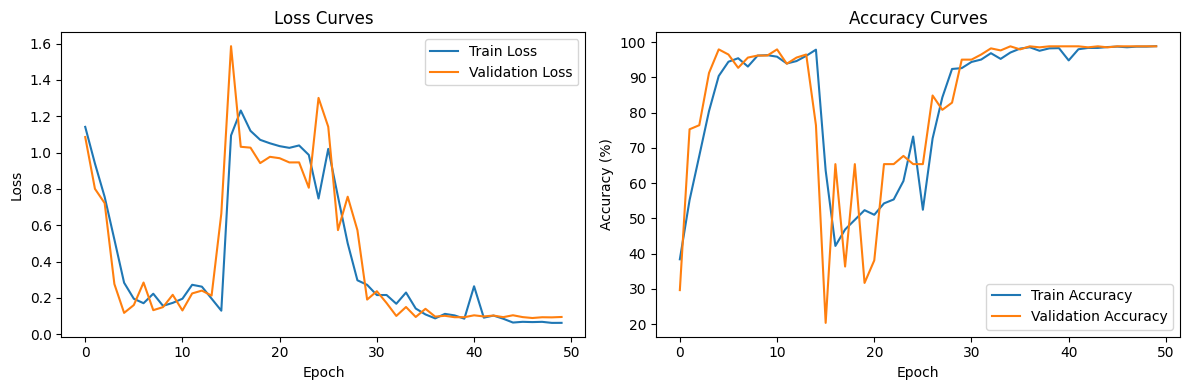


Overall Test Accuracy: 97.97%

Per-Class Test Accuracy:
hello: 94.44% (51/54)
negative: 98.63% (216/219)
thank_you: 98.61% (71/72)

Detailed Classification Report:
              precision    recall  f1-score   support

       hello       1.00      0.94      0.97        54
    negative       0.99      0.99      0.99       219
   thank_you       0.95      0.99      0.97        72

    accuracy                           0.98       345
   macro avg       0.98      0.97      0.97       345
weighted avg       0.98      0.98      0.98       345



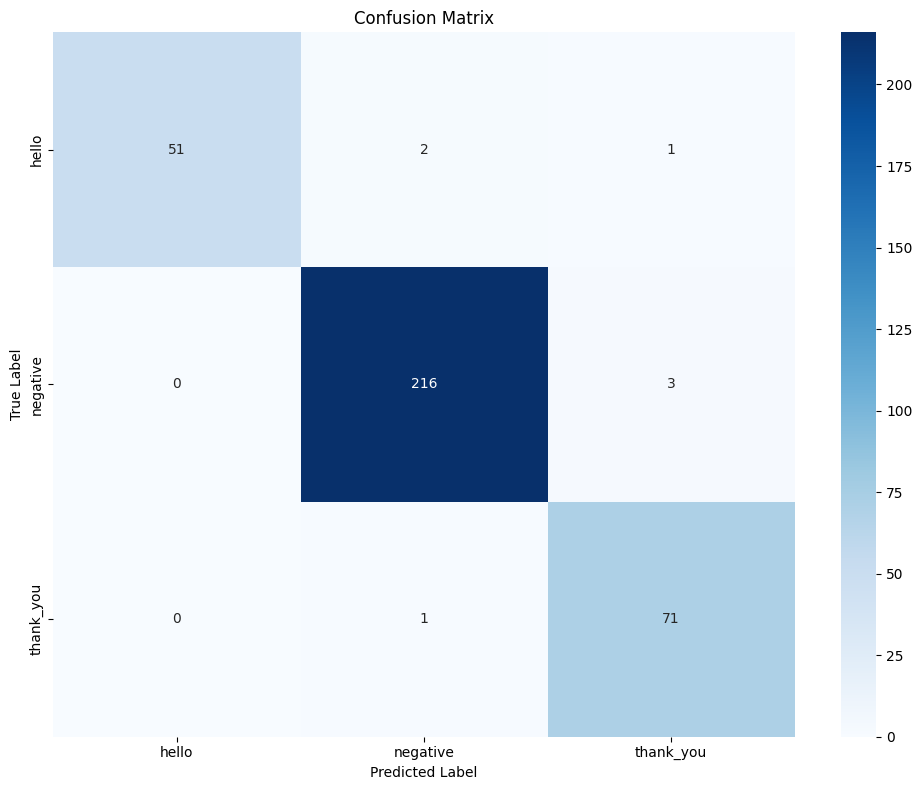

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time
import h5py

class ImprovedLandmarkLSTM(nn.Module):
    def __init__(
        self,
        input_size=63,
        hidden_size=256,
        num_layers=3,
        num_classes=3,
        dropout_rate=0.4
    ):
        super(ImprovedLandmarkLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, num_classes)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Custom weight initialization
        """
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

        if isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        """
        Forward pass of the enhanced LSTM model
        """
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)

        out = self.fc(out)

        return out

def calculate_class_weights(features_path):
    class_to_idx = {
        'hello': 0,
        'negative': 1,
        'thank_you': 2
    }

    label_counts = {cls: 0 for cls in class_to_idx.keys()}

    with h5py.File(features_path, 'r') as h5file:
        for class_name, class_group in h5file.items():
            label_counts[class_name] = len(list(class_group.values()))

    total_samples = sum(label_counts.values())
    class_weights = {
        cls: np.sqrt(total_samples / (len(class_to_idx) * count))
        for cls, count in label_counts.items()
    }

    weights_tensor = torch.tensor([
        class_weights['hello'],
        class_weights['negative'],
        class_weights['thank_you']
    ], dtype=torch.float)

    print("Class Weights:")
    for cls, weight in class_weights.items():
        print(f"{cls}: {weight:.2f}")

    return weights_tensor

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=50,
    save_path='/content/drive/MyDrive/project_data/best_model.pth'
):
    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_acc = 0
    best_epoch = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"{'='*50}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        class_correct = {0: 0, 1: 0, 2: 0}
        class_total = {0: 0, 1: 0, 2: 0}

        train_progress = tqdm(train_loader, desc="Training", leave=False)
        for batch_landmarks, labels in train_progress:
            batch_landmarks = batch_landmarks.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(batch_landmarks)
            loss = criterion(outputs, labels)

            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            batch_correct = (predicted == labels).sum().item()
            train_correct += batch_correct

            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1

            scheduler.step()

            train_progress.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * batch_correct / labels.size(0):.2f}%',
                'LR': f'{scheduler.get_last_lr()[0]:.6f}'
            })

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        val_class_correct = {0: 0, 1: 0, 2: 0}
        val_class_total = {0: 0, 1: 0, 2: 0}

        val_progress = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for batch_landmarks, labels in val_progress:
                batch_landmarks = batch_landmarks.to(device)
                labels = labels.to(device)

                outputs = model(batch_landmarks)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                batch_correct = (predicted == labels).sum().item()
                val_correct += batch_correct

                for i in range(len(labels)):
                    label = labels[i].item()
                    val_class_total[label] += 1
                    if predicted[i] == labels[i]:
                        val_class_correct[label] += 1

                val_progress.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100 * batch_correct / labels.size(0):.2f}%'
                })

        train_epoch_loss = train_loss / len(train_loader)
        train_epoch_acc = 100 * train_correct / train_total
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total

        current_lr = scheduler.get_last_lr()[0]

        history['train_loss'].append(train_epoch_loss)
        history['train_acc'].append(train_epoch_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        history['lr'].append(current_lr)

        print(f"\nEpoch Summary:")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}%")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

        print("\nPer-Class Training Accuracy:")
        class_names = ['hello', 'negative', 'thank_you']
        for i, name in enumerate(class_names):
            acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            print(f"{name}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

        print("\nPer-Class Validation Accuracy:")
        for i, name in enumerate(class_names):
            acc = 100 * val_class_correct[i] / val_class_total[i] if val_class_total[i] > 0 else 0
            print(f"{name}: {acc:.2f}% ({val_class_correct[i]}/{val_class_total[i]})")

        if val_epoch_acc > best_val_acc:
            improvement = val_epoch_acc - best_val_acc
            print(f"\n🌟 New Best Model! Validation Accuracy improved by {improvement:.2f}%")
            best_val_acc = val_epoch_acc
            best_epoch = epoch + 1

            torch.save({
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history
            }, save_path)
            print(f"Best model saved to {save_path}")

        elapsed_time = time.time() - start_time
        avg_epoch_time = elapsed_time / (epoch + 1)
        estimated_remaining = avg_epoch_time * (num_epochs - epoch - 1)

        print(f"\nTime Stats:")
        print(f"Elapsed Time: {elapsed_time/60:.2f} mins")
        print(f"Est. Remaining: {estimated_remaining/60:.2f} mins")
    print("\n" + "="*50)
    print("Training Completed")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print("="*50)

    return model, history

def main():
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 50


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    features_path = '/content/drive/MyDrive/project_data/landmark_features.h5'

    best_model_path = '/content/drive/MyDrive/project_data/best_asl_landmark_model.pth'

    train_loader, val_loader, test_loader = get_data_loaders(
        features_path=features_path,
        batch_size=BATCH_SIZE,
        num_workers=8,
        pin_memory=True
    )

    classes = ['hello', 'negative', 'thank_you']

    class_weights = calculate_class_weights(features_path).to(device)

    model = ImprovedLandmarkLSTM(
        input_size=63,
        hidden_size=256,
        num_layers=3,
        num_classes=len(classes),
        dropout_rate=0.4
    )

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        pct_start=0.3,
        div_factor=10,
        final_div_factor=100
    )

    trained_model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        num_epochs=NUM_EPOCHS,
        save_path=best_model_path
    )
    plot_training_history(history)

    evaluate_model(
        trained_model,
        test_loader,
        device,
        classes
    )

if __name__ == "__main__":
    main()